In [1]:
import numpy as np,os # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import os
from scipy.stats import wilcoxon, friedmanchisquare, rankdata, trim_mean
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

In [2]:
def process(res,lev=0):
    res = res.rename(columns={'bbag_DT':'BagDT','bbag_NB':'BagNB'},level=1)
    
    fils = set(res.columns.get_level_values(lev))
    dic = {}
    for c in fils:
        if lev==0:
            dic[c] = res[c].sort_index(axis=1).values.reshape(-1)
        elif lev==1:
            dic[c] = res.loc[:,(slice(None),c)].sort_index(axis=1).values.reshape(-1)
    return pd.DataFrame(dic)

In [3]:
mcc = pd.read_csv(f"Results/All_filter_MCC.csv",header=[0,1],index_col=0)
prc = pd.read_csv(f"Results/All_filter_PRC.csv",header=[0,1],index_col=0)
mcc = process(mcc,lev=0)
prc = process(prc,lev=0)

In [4]:
n_mcc = mcc['none']
n_prc = prc['none']
mcc.drop(columns=['none'],inplace=True)
prc.drop(columns=['none'],inplace=True)

In [5]:
for c in mcc:
    mcc[c] = mcc[c] - n_mcc
    prc[c] = prc[c] - n_prc

In [6]:
comb = pd.concat([pd.melt(mcc.assign(Metric='dMCC'),id_vars='Metric'),
                  pd.melt(prc.assign(Metric='dAPRC'),id_vars='Metric')],axis=0)
comb.columns =['Metric', 'Filter', 'Value']
comb.shape,comb.columns

((4608, 3), Index(['Metric', 'Filter', 'Value'], dtype='object'))

In [7]:
comb.Filter = comb.Filter.apply(lambda x:x.upper())
comb.Filter = comb.Filter.apply(lambda x:'SPIDER2' if x=='SPYDER' else x)

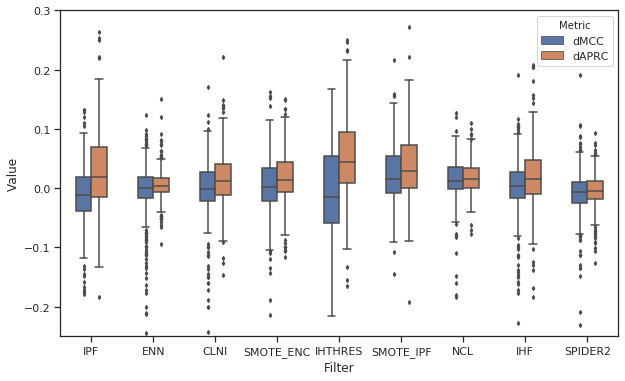

In [8]:
plt.figure(figsize=(10,6))
plt.ylim(-.25,.3)
f = sns.boxplot(x='Filter',y='Value',data=comb,hue='Metric',width=.5,fliersize=3);

In [9]:
df = {}
for c in mcc:
    pv = wilcoxon(mcc[c]+n_mcc,n_mcc).pvalue
    eff = pg.effsize.compute_effsize(mcc[c]+n_mcc,n_mcc,paired=True,eftype='hedges')
    print(f"{c} & {trim_mean(mcc[c]+n_mcc,.05):.4f} & {pv} & {eff:.4f} &")

ipf & 0.2752 & 0.00023018848918810212 & -0.1308 &
enn & 0.2762 & 0.8153091730918904 & -0.0795 &
clni & 0.2765 & 0.8534851563741173 & -0.0988 &
smote_enc & 0.2885 & 0.30239811748937506 & 0.0380 &
ihthres & 0.2776 & 0.16385617745041692 & -0.0788 &
smote_ipf & 0.3097 & 5.155699125599004e-12 & 0.2746 &
ncl & 0.3001 & 2.510080989317358e-14 & 0.1555 &
ihf & 0.2811 & 0.21637828059559816 & -0.0612 &
spyder & 0.2738 & 0.0006927655575768012 & -0.1210 &


In [10]:
for c in prc:
    pv = wilcoxon(prc[c]+n_prc,n_prc).pvalue
    eff = pg.effsize.compute_effsize(prc[c]+n_prc,n_prc,paired=True,eftype='hedges')
    print(f"{c},{trim_mean(prc[c]+n_prc,.05):.4f} & {pv} & {eff:.4f}")

ipf,0.4358 & 6.366451858088375e-10 & 0.2052
enn,0.4089 & 0.00034186773441726527 & 0.0449
clni,0.4199 & 2.6792559680572654e-07 & 0.1192
smote_enc,0.4214 & 5.166334510568681e-10 & 0.1192
ihthres,0.4550 & 4.625028696968434e-24 & 0.3559
smote_ipf,0.4437 & 4.5662260282068795e-20 & 0.2737
ncl,0.4207 & 2.720067986272718e-20 & 0.1269
ihf,0.4242 & 9.848930358674078e-09 & 0.1380
spyder,0.3976 & 0.013546888390769746 & -0.0390


## Classifier-based View

In [11]:
mcc = pd.read_csv(f"Results/All_filter_MCC.csv",header=[0,1],index_col=0)
prc = pd.read_csv(f"Results/All_filter_PRC.csv",header=[0,1],index_col=0)
mcc = mcc.rename(columns={'bbag_DT':'BagDT','bbag_NB':'BagNB'},level=1)
prc = prc.rename(columns={'bbag_DT':'BagDT','bbag_NB':'BagNB'},level=1)
prc.shape

(32, 80)

In [12]:
n_mcc = mcc['none']
n_prc = prc['none']
mcc.drop(columns=['none'],inplace=True)
prc.drop(columns=['none'],inplace=True)

/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [13]:
mcc.columns.names = ['Filter', 'clf']
prc.columns.names = ['Filter', 'clf']

In [14]:
mcc_med = mcc.max(axis=1,level=1) - n_mcc
prc_med = prc.max(axis=1,level=1) - n_prc #.sort_index(axis=1)

In [15]:
comb = pd.concat([pd.melt(mcc_med.assign(Metric='dMCC'),id_vars=['Metric']),
                pd.melt(prc_med.assign(Metric='dAPRC'),id_vars=['Metric'])])
comb.columns = ['Metric', 'Classifier', 'Value']
comb.shape,comb.columns

((512, 3), Index(['Metric', 'Classifier', 'Value'], dtype='object'))

In [16]:
comb['Classifier'] = comb['Classifier'].apply(lambda x: x.upper() if x.islower() else x)

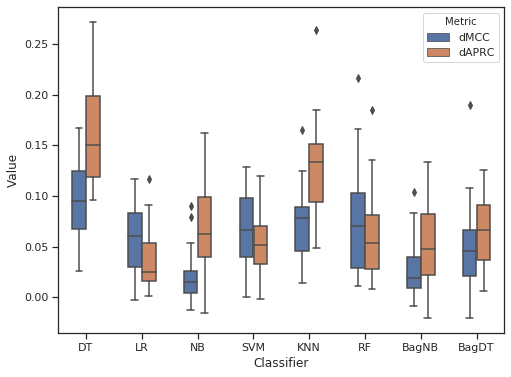

In [17]:
plt.figure(figsize=(8,6))
f = sns.boxplot(x='Classifier',y='Value',data=comb,hue='Metric',width=.5);